In [1]:
%pylab inline
#import matplotlib as mpl
#mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import h5py, itertools, scipy.stats
import matplotlib.pyplot as plt
import sys, os, re
from scipy.special import erf
from scipy.optimize import curve_fit
from random import gauss

In [ ]:
#Here are the columns from the Hugs data 
#
#Cols. 1,2: (X,Y) stellar position in a reference system where the cluster center is in (5000,5000)
# Col.  3: F275W calibrated magnitude
# Col.  4: F275W photometric RMS
# Col.  5: F275W quality-fit parameter
# Col.  6: F275W sharp parameter 
# Col.  7: Number of F275W exposures the source is found in [99: saturated star]
# Col.  8: Number of F275W exposures the source is well measured [99: saturated star]
# Col.  9: F336W calibrated magnitude
# Col. 10: F336W photometric RMS
# Col. 11: F336W quality-fit parameter
# Col. 12: F336W sharp parameter
# Col. 13: Number of F336W exposures the source is found in [99: saturated star]
# Col. 14: Number of F336W exposures the source is well measured [99: saturated star]
# Col. 15: F438W calibrated magnitude
# Col. 16: F438W photometric RMS
# Col. 17: F438W quality-fit parameter
# Col. 18: F438W sharp parameter 
# Col. 19: Number of F438W exposures the source is found in [99: saturated star]
# Col. 20: Number of F438W exposures the source is well measured [99: saturated star]
# Col. 21: F606W calibrated magnitude
# Col. 22: F606W photometric RMS
# Col. 23: F606W quality-fit parameter
# Col. 24: F606W sharp parameter 
# Col. 25: Number of F606W exposures the source is found in [99: saturated star]
# Col. 26: Number of F606W exposures the source is well measured [99: saturated star]
# Col. 27: F814W calibrated magnitude
# Col. 28: F814W photometric RMS
# Col. 29: F814W quality-fit parameter
# Col. 30: F814W sharp parameter
# Col. 31: Number of F814W exposures the source is found in [99: saturated star]
# Col. 32: Number of F814W exposures the source is well measured [99: saturated star]
# Col. 33: Membership Probability [-1.0: not available]
# Cols. 34,35: Right ascension (J2000, epoch 2015.0) and 
#              Declination (J2000, epoch J2015.0) of the star, astrometrized using Gaia DR1 (Lindegren et al. 2016)  
# Cols. 36: Identification number of the star
# Cols. 37: Iteration the star was found 
#           1-5: found in F606W & F814W images 
#             6: found in F438W  images 
#             7: found in F336W  images 
#             8: found in F275W  images

In [3]:
f = np.loadtxt('./Hugs_photometry/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc2808_multi_v1_catalog-meth1.txt',
              dtype=object)

343134 22604 203744


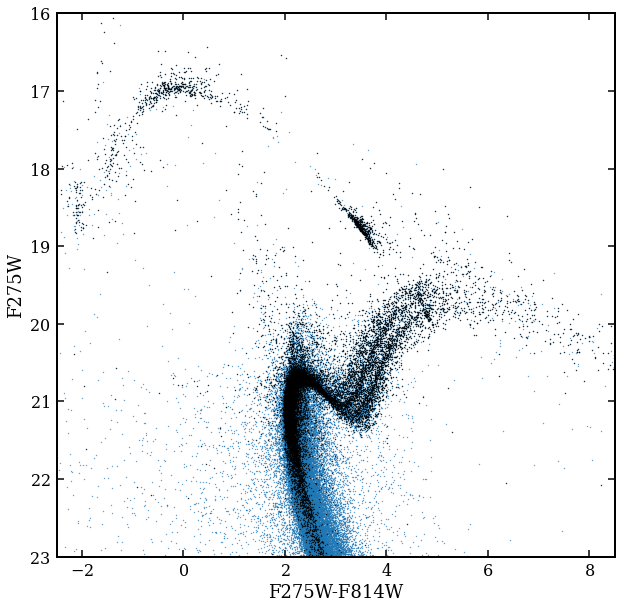

In [253]:
F275 = np.array(f[:,2],dtype=float)
F336 = np.array(f[:,8],dtype=float)
F438 = np.array(f[:,14],dtype=float)
F606 = np.array(f[:,21],dtype=float)
F814 = np.array(f[:,26],dtype=float)

F275_RMS = np.array(f[:,3],dtype=float)
F336_RMS = np.array(f[:,9],dtype=float)
F438_RMS = np.array(f[:,15],dtype=float)
F606_RMS = np.array(f[:,22],dtype=float)
F814_RMS = np.array(f[:,27],dtype=float)

#now I need to mask out the weird values (photometry set to -99.99999) and stars with
#large errors F275W > 0.03, F336W > 0.03, F438W > 0.02
obs_mask = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)&(F275_RMS<0.03)&(F336_RMS<0.03)&(F438_RMS<0.02)
obs_mask_no_err = (F275>-99.0)&(F336>-99.0)&(F438>-99.0)&(F606>-99.0)&(F814>-99.0)

print(len(F275),np.sum(obs_mask),np.sum(obs_mask_no_err))

F275_orig = F275.copy()
F336_orig = F336.copy()
F438_orig = F438.copy()
F606_orig = F606.copy()
F814_orig = F814.copy()

F275 = F275[obs_mask]
F336 = F336[obs_mask]
F438 = F438[obs_mask]
F606 = F606[obs_mask]
F814 = F814[obs_mask]

fig1 = figure(1,(10,10))
plt.scatter(F275_orig-F814_orig,F275_orig,color='C0',s=0.1)
plt.scatter(F275-F814,F275,color='k',s=0.1)
plt.xlim([-2.5,8.5])
plt.ylim([23,16])
plt.xlabel('F275W-F814W')
plt.ylabel('F275W')
plt.show()

In [254]:
def poly_three(x,pconv):
    return pconv[0]*np.power(x,3.0)+pconv[1]*np.power(x,2.0)+pconv[2]*np.power(x,1)+pconv[3]

def poly_four(x,pconv):
    return pconv[0]*np.power(x,4.0)+pconv[1]*np.power(x,3.0)+pconv[2]*np.power(x,2.0)+pconv[3]*np.power(x,1)+pconv[4]

def poly_one(x,pconv):
    return pconv[0]*x+pconv[1]


[ -0.18422558   3.4043454  -22.9908519   66.62493257 -49.        ]
[ -0.18422558   3.4043454  -22.9908519   66.62493257 -49.09038166]


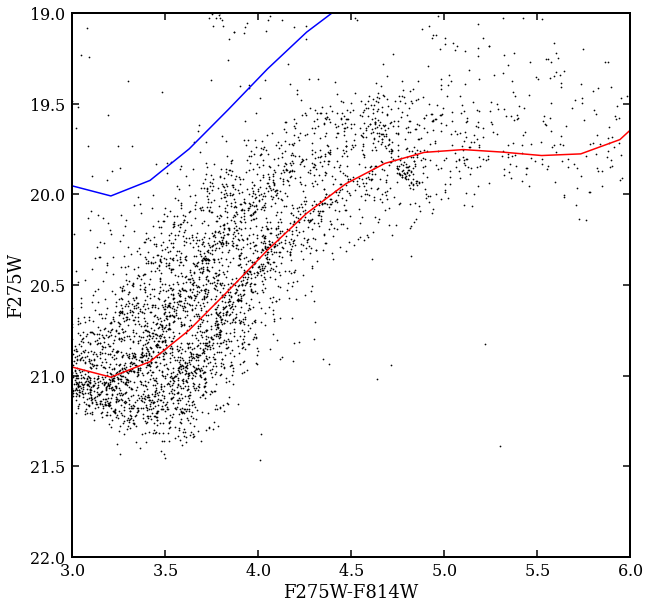

In [257]:
#Okay this is wild but I want to calculate this Chromosome plot which is a really confusing 
#combination of magnitudes
#
# Delta_F275W,F814W =. W_F275W,F814W * (X - X_fiducial,R) / (X_fiducial, R - X_fiducial, B)
#
# The first thing I need to do is somehow measure the red and blue edges of the RGB
# Lets zoom in on the RGB

mask_RGB = (F275>19.)&(F275<21.5)&(F275-F814>3.0)&(F275-F814<6.0)

#p = np.polyfit(F275[mask_RGB]-F814[mask_RGB],F275[mask_RGB],3)
p = np.polyfit(F275[mask_RGB]-F814[mask_RGB],F275[mask_RGB],4)
#p = np.polyfit(F275[mask_RGB]-F814[mask_RGB],F275[mask_RGB],1)

p_orig = p.copy()
#print(p)
p[4] = -50.0
p_blue = p.copy()
p[4] = -49.0
p_red = p.copy()
print(p_red)
print(p_orig)
xx = np.linspace(3.0,7.0,20)
#yy = poly_three(xx,p)
#yy_orig = poly_four(xx,p_orig)
#yy = poly_four(xx,p)
yy_blue = poly_four(xx,p_blue)
yy_red = poly_four(xx,p_red)
#yy = line_fit(xx,p)

fig1 = figure(1,(10,10))
plt.scatter(F275[mask_RGB]-F814[mask_RGB],F275[mask_RGB],color='k',s=0.5)
plt.plot(xx,yy_orig)
plt.plot(xx,yy_red,color='r')
plt.plot(xx,yy_blue,color='b')
plt.xlim([3.0,6.0])
plt.ylim([22,19])
plt.xlabel('F275W-F814W')
plt.ylabel('F275W')
plt.show()

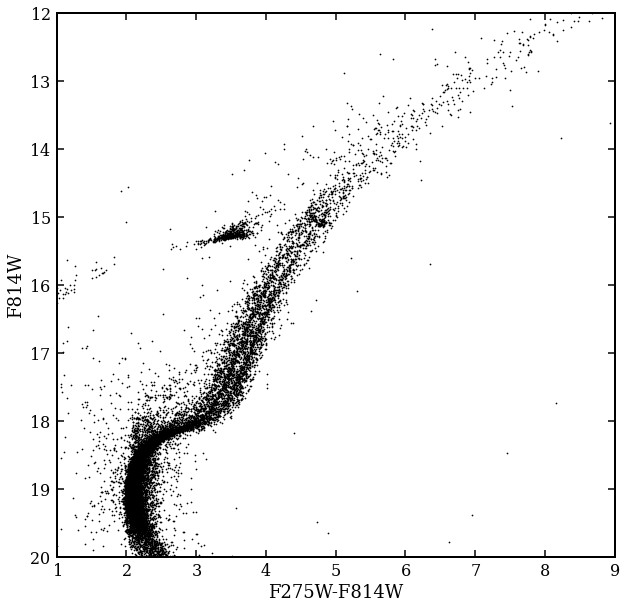

In [258]:
fig1 = figure(1,(10,10))
plt.scatter(F275-F814,F814,color='k',s=0.5)
#plt.plot(xx,yy_orig)
#plt.plot(xx,yy_red,color='r')
#plt.plot(xx,yy_blue,color='b')
plt.xlim([1.0,9.0])
plt.ylim([20,12])
plt.xlabel('F275W-F814W')
plt.ylabel('F814W')
plt.show()

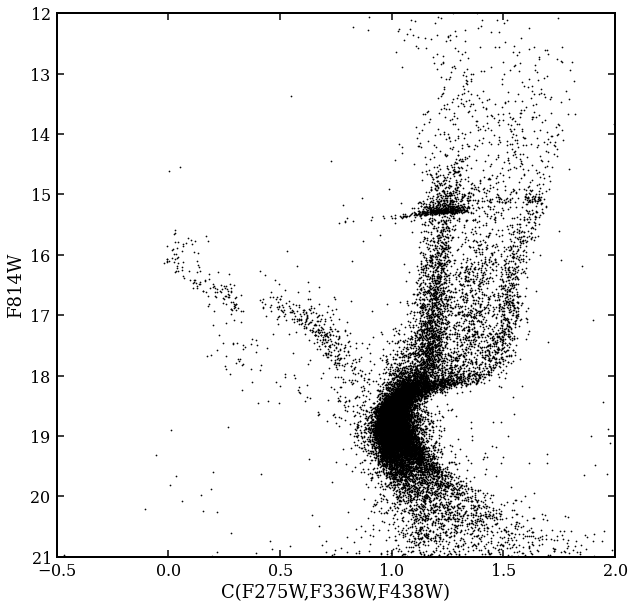

In [259]:
fig1 = figure(1,(10,10))
plt.scatter((F275-F336)-(F336-F438),F814,color='k',s=0.5)
#plt.plot(xx,yy_orig)
#plt.plot(xx,yy_red,color='r')
#plt.plot(xx,yy_blue,color='b')
plt.xlim([-0.5,2.0])
plt.ylim([21,12])
plt.xlabel('C(F275W,F336W,F438W)')
plt.ylabel('F814W')
plt.show()

[ -0.18422558   3.4043454  -22.9908519   65.62493257 -49.09038166]


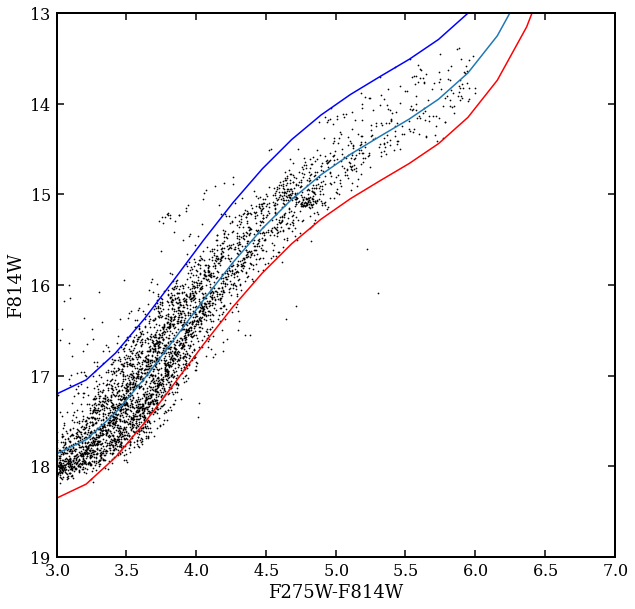

In [276]:
p = np.polyfit(F275[mask_RGB]-F814[mask_RGB],F814[mask_RGB],4)

p_orig = p.copy()
print(p_orig)
p[4] = -49.75
p_blue = p.copy()
p[4] = -48.6
p_red = p.copy()
#print(p_red)
#print(p_orig)
xx = np.linspace(3.0,7.0,20)
#yy = poly_three(xx,p)
yy_orig = poly_four(xx,p_orig)
#yy = poly_four(xx,p)
yy_blue = poly_four(xx,p_blue)
yy_red = poly_four(xx,p_red)
#yy = line_fit(xx,p)


fig1 = figure(1,(10,10))
plt.scatter(F275[mask_RGB]-F814[mask_RGB],F814[mask_RGB],color='k',s=0.5)
plt.plot(xx,yy_orig)
plt.plot(xx,yy_red,color='r')
plt.plot(xx,yy_blue,color='b')
plt.xlim([3.0,7.0])
plt.ylim([19,13])
plt.xlabel('F275W-F814W')
plt.ylabel('F814W')
plt.show()

In [277]:
#for every value of F814W invert the polynomial and solve for the corresponding color on
#the red line
#
#Do this by defining an equation that is zero
from scipy.optimize import fsolve
Red_list, Blue_list = [],[]
for Mag in F814[mask_RGB]:
    func_R = lambda X_R: Mag - poly_four(X_R,p_red)
    func_B = lambda X_B: Mag - poly_four(X_B,p_blue)
    Red_list.append(fsolve(func_R,4.0)[0])
    Blue_list.append(fsolve(func_B,4.0)[0])

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


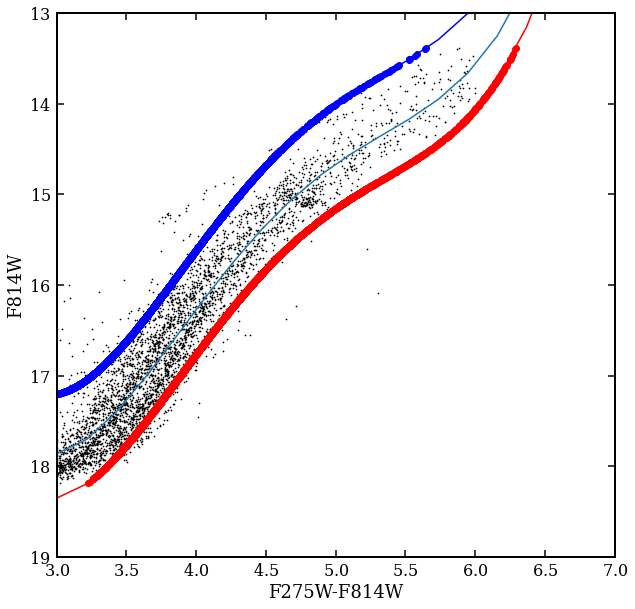

In [278]:
fig1 = figure(1,(10,10))
plt.scatter(F275[mask_RGB]-F814[mask_RGB],F814[mask_RGB],color='k',s=0.5)
plt.scatter(Red_list,F814[mask_RGB],color='r')
plt.scatter(Blue_list,F814[mask_RGB],color='b')
plt.plot(xx,yy_orig)
plt.plot(xx,yy_red,color='r')
plt.plot(xx,yy_blue,color='b')
plt.xlim([3.0,7.0])
plt.ylim([19,13])
plt.xlabel('F275W-F814W')
plt.ylabel('F814W')
plt.show()

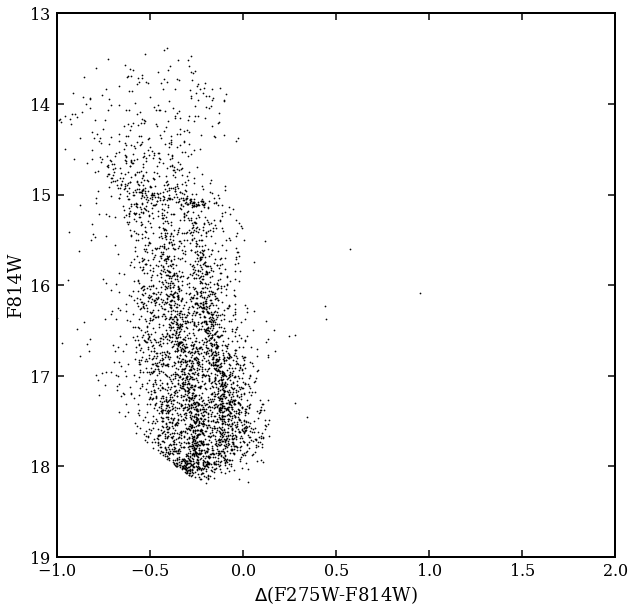

In [279]:
#Delta_F275_F814 = np.divide((F275[mask_RGB]-F814[mask_RGB])-np.array(Red_list),
#                            (np.array(Red_list)-np.array(Blue_list)))

Delta_F275_F814 = (F275[mask_RGB]-F814[mask_RGB])-np.array(Red_list)

fig1 = figure(1,(10,10))
plt.scatter(Delta_F275_F814,F814[mask_RGB],color='k',s=0.5)
plt.xlim([-1,2.0])
plt.ylim([19,13])
plt.xlabel('$\Delta$(F275W-F814W)')
plt.ylabel('F814W')
plt.show()

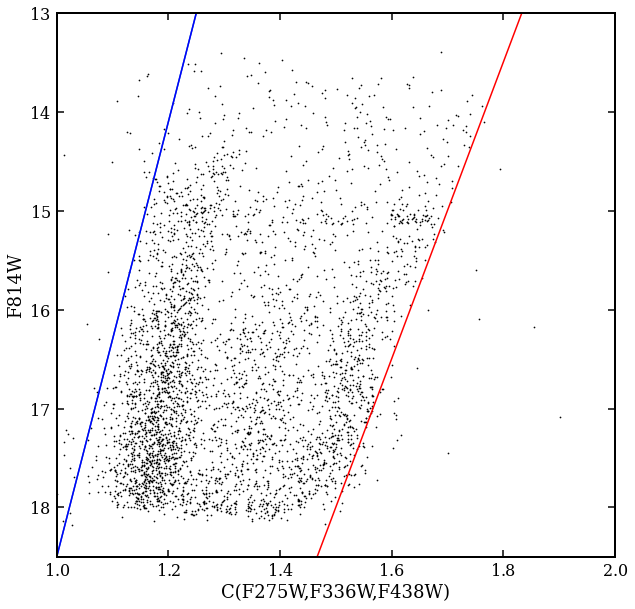

In [280]:
#Okay now I need to calculate delta of the pseudo color

#p_pseudo = np.polyfit((F275[mask_RGB]-F336[mask_RGB])-(F336[mask_RGB]-F438[mask_RGB]),F814[mask_RGB],1)
#p_orig_pseudo = p_pseudo.copy()
#p_orig_pseudo = [-15.0,40.5]
#p_orig_pseudo = [-22.0,40.5]
#print(p_orig_pseudo)
#p_pseudo[4] = -50.0
p_blue_pseudo = [-22.0,40.5]
#p_pseudo[4] = -49.0
p_red_pseudo = [-15.0,40.5]
#print(p_red)
#print(p_orig)
xx = np.linspace(1.0,2.0,20)
#yy = poly_three(xx,p)
#yy_orig_pseudo = poly_one(xx,p_orig_pseudo)
#yy = poly_four(xx,p)
yy_blue_pseudo = poly_one(xx,p_blue_pseudo)
yy_red_pseudo = poly_one(xx,p_red_pseudo)
#yy = line_fit(xx,p)

fig1 = figure(1,(10,10))
plt.scatter((F275[mask_RGB]-F336[mask_RGB])-(F336[mask_RGB]-F438[mask_RGB]),F814[mask_RGB],color='k',s=0.5)
plt.plot(xx,yy_orig_pseudo)
plt.plot(xx,yy_red_pseudo,color='r')
plt.plot(xx,yy_blue_pseudo,color='b')
plt.xlim([1.0,2.0])
plt.ylim([18.5,13])
plt.xlabel('C(F275W,F336W,F438W)')
plt.ylabel('F814W')
plt.show()

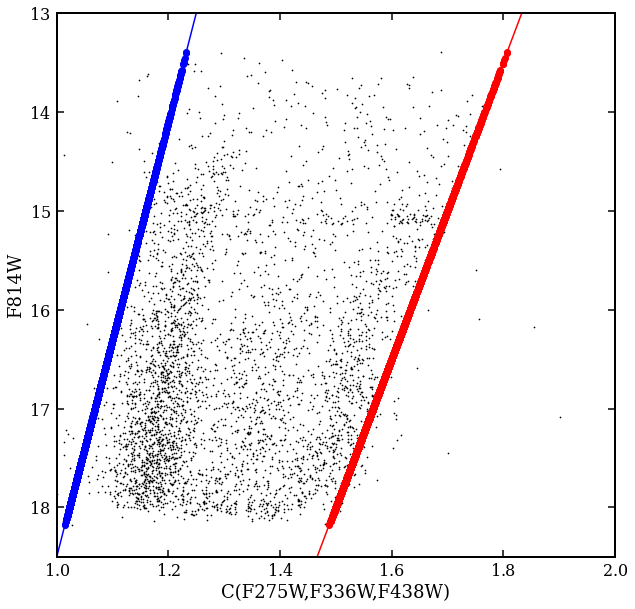

In [281]:
#Solve the pseudo color equations

Red_list_pseudo, Blue_list_pseudo = [],[]
for Mag in F814[mask_RGB]:
    func_R = lambda X_R: Mag - poly_one(X_R,p_red_pseudo)
    func_B = lambda X_B: Mag - poly_one(X_B,p_blue_pseudo)
    Red_list_pseudo.append(fsolve(func_R,1.2)[0])
    Blue_list_pseudo.append(fsolve(func_B,1.2)[0])
    
fig1 = figure(1,(10,10))
plt.scatter((F275[mask_RGB]-F336[mask_RGB])-(F336[mask_RGB]-F438[mask_RGB]),F814[mask_RGB],color='k',s=0.5)
plt.scatter(Red_list_pseudo,F814[mask_RGB],color='r')
plt.scatter(Blue_list_pseudo,F814[mask_RGB],color='b')
#plt.plot(xx,yy_orig)
plt.plot(xx,yy_red_pseudo,color='r')
plt.plot(xx,yy_blue_pseudo,color='b')
plt.xlim([1.0,2.0])
plt.ylim([18.5,13])
plt.xlabel('C(F275W,F336W,F438W)')
plt.ylabel('F814W')
plt.show()

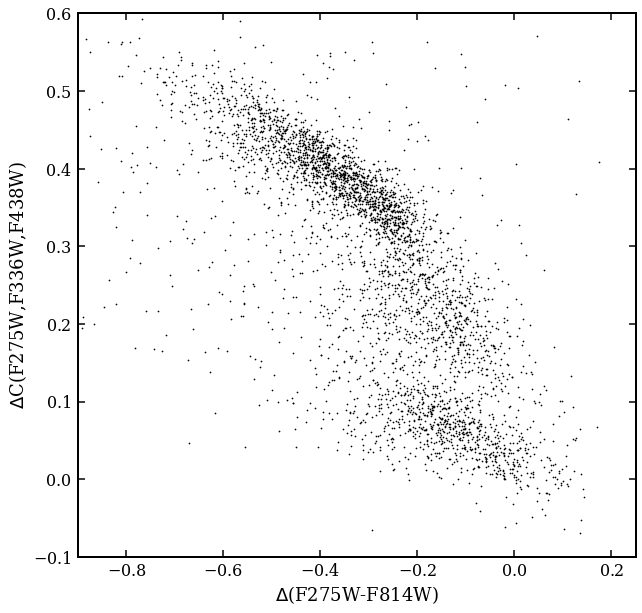

In [282]:
#Delta_pseudo = np.divide(np.array(Red_list_pseudo)-((F275[mask_RGB]-F336[mask_RGB])-(F336[mask_RGB]-F438[mask_RGB])),
#                            (np.array(Red_list_pseudo)-np.array(Blue_list_pseudo)))

Delta_pseudo = np.array(Red_list_pseudo)-((F275[mask_RGB]-F336[mask_RGB])-(F336[mask_RGB]-F438[mask_RGB]))
fig1 = figure(1,(10,10))
plt.scatter(Delta_F275_F814,Delta_pseudo,color='k',s=0.5)
plt.xlim([-0.9,0.25])
plt.ylim([-0.1,0.6])
plt.xlabel(r'$\Delta$(F275W-F814W)')
plt.ylabel(r'$\Delta$C(F275W,F336W,F438W)')
plt.show()

In [293]:
#Even though it's slightly off, I still want to try to do a k-means clustering on this to
#see if I can recover the differen pops
from sklearn.cluster import KMeans

mask_chromosome = (Delta_F275_F814>-0.75)&(Delta_F275_F814<0.25)&(Delta_pseudo>-0.1)&(Delta_pseudo<0.6)
X_data = np.vstack((Delta_F275_F814[mask_chromosome],Delta_pseudo[mask_chromosome])).T


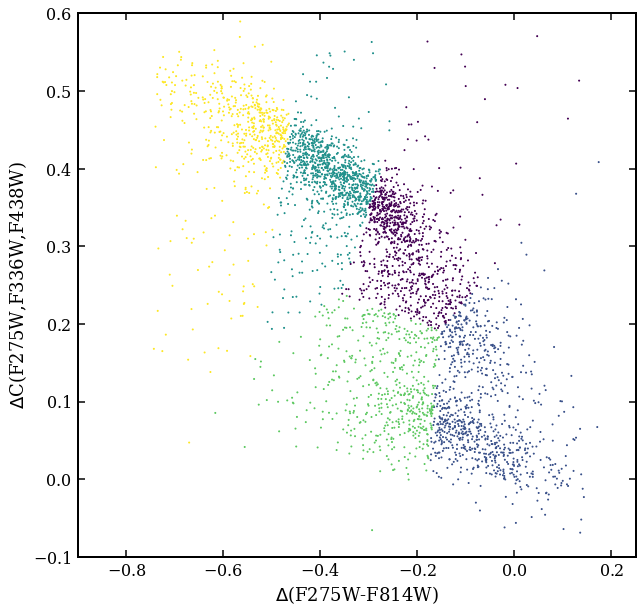

In [294]:
estimator = KMeans(n_clusters=5,max_iter=1000,n_init=20,algorithm='full')
estimator.fit(X_data)
labels=estimator.labels_

plt.figure(1,(10,10))
plt.scatter(X_data[:,0],X_data[:,1],c=labels.astype(float),s=1)
plt.xlim([-0.9,0.25])
plt.ylim([-0.1,0.6])
plt.xlabel(r'$\Delta$(F275W-F814W)')
plt.ylabel(r'$\Delta$C(F275W,F336W,F438W)')
plt.show()

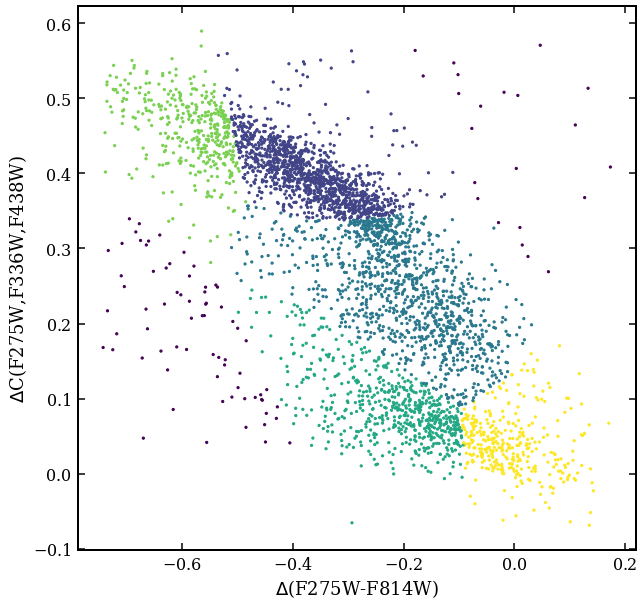

In [303]:
#okay for some reason k-means sucks at this so lets try another one, SpectralClustering

from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=6,assign_labels='kmeans')
labels = model.fit_predict(X_data)


plt.figure(1,(10,10))
plt.scatter(X_data[:,0],X_data[:,1],c=labels.astype(float),s=5)
#plt.xlim([-0.9,0.25])
#plt.ylim([-0.1,0.6])
plt.xlabel(r'$\Delta$(F275W-F814W)')
plt.ylabel(r'$\Delta$C(F275W,F336W,F438W)')
plt.show()

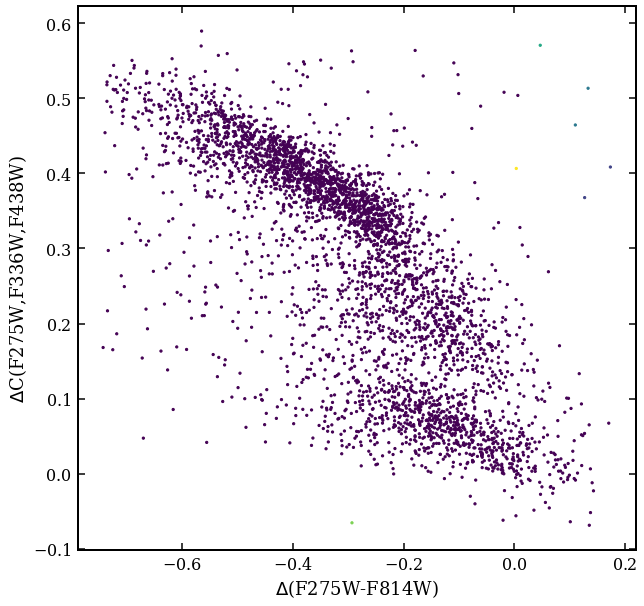

In [315]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=6,linkage='single')
labels = model.fit_predict(X_data)


plt.figure(1,(10,10))
plt.scatter(X_data[:,0],X_data[:,1],c=labels.astype(float),s=5)
#plt.xlim([-0.9,0.25])
#plt.ylim([-0.1,0.6])
plt.xlabel(r'$\Delta$(F275W-F814W)')
plt.ylabel(r'$\Delta$C(F275W,F336W,F438W)')
plt.show()